In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
import cv2
import pandas as pd
import numpy as np
import os

In [2]:
# dictonary
clsTrnslt = {
    "cane": "Dog",
    "cavallo": "Horse",
    "elefante": "Elephant",
    "farfalla": "Butterfly",
    "gallina": "Chicken",
    "gatto": "Cat",
    "mucca": "Cow",
    "pecora": "Sheep",
    "scoiattolo": "Squirrel",
    "ragno": "Spider"
}

In [3]:
# data path name
Folder_Path_Name = os.listdir('/kaggle/input/animals10/raw-img/')
# empty list
File_In_Folder1 = []
File_In_Folder2 = []
Target_File_In_Folder1 = []
Target_File_In_Folder2 = []

In [4]:
# loop
for x, Fldr_Name in enumerate(Folder_Path_Name):
    # assign files
    File_Names = os.listdir('/kaggle/input/animals10/raw-img/' + Fldr_Name)
    # counter
    Cnt_Var = 0
    # iterate items one by one from File_Names
    for Each_File in File_Names:
        # if counter value is less than 1400, items will be append on File_In_Folder1 list
        if Cnt_Var < 1400:
            File_In_Folder1.append('/kaggle/input/animals10/raw-img/' + Fldr_Name + '/' + Each_File)
            Target_File_In_Folder1.append(clsTrnslt[Fldr_Name])
        # else items will be appended in File_In_Folder2 list
        else:
            File_In_Folder2.append('/kaggle/input/animals10/raw-img/' + Fldr_Name + '/' + Each_File)
            Target_File_In_Folder2.append(clsTrnslt[Fldr_Name])
        # countter value increased 
        Cnt_Var += 1

In [5]:
# create a dataframe that has file names and their class translation name from File_In_Folder1 and Target_File_In_Folder1
Data_Frame1 = pd.DataFrame(
    {
        'Filepath_Name': File_In_Folder1,
        'Target_F_Name': Target_File_In_Folder1
    }
)

In [6]:
# create a dataframe that has file names and their class translation name from File_In_Folder2 and Target_File_In_Folder2
Data_Frame2 = pd.DataFrame(
    {
        'Filepath_Name': File_In_Folder2,
        'Target_F_Name': Target_File_In_Folder2
    }
)

In [7]:
# printing dataframe1 and dataframe2
print(f"DataFrame1 =\n___________________________________________________________________________\n"
      f"{Data_Frame1}"
      f"\n___________________________________________________________________________\n")

print(f"DataFrame2 =\n___________________________________________________________________________\n"
      f"{Data_Frame2}"
      f"\n___________________________________________________________________________\n")

DataFrame1 =
___________________________________________________________________________
                                           Filepath_Name Target_F_Name
0      /kaggle/input/animals10/raw-img/cavallo/OIP-md...         Horse
1      /kaggle/input/animals10/raw-img/cavallo/OIP-TP...         Horse
2      /kaggle/input/animals10/raw-img/cavallo/OIP-jl...         Horse
3      /kaggle/input/animals10/raw-img/cavallo/OIP-F4...         Horse
4      /kaggle/input/animals10/raw-img/cavallo/OIP-UF...         Horse
...                                                  ...           ...
13995  /kaggle/input/animals10/raw-img/farfalla/OIP-r...     Butterfly
13996  /kaggle/input/animals10/raw-img/farfalla/ea36b...     Butterfly
13997  /kaggle/input/animals10/raw-img/farfalla/OIP-s...     Butterfly
13998  /kaggle/input/animals10/raw-img/farfalla/OIP-Y...     Butterfly
13999  /kaggle/input/animals10/raw-img/farfalla/OIP-_...     Butterfly

[14000 rows x 2 columns]
_________________________________

In [8]:
# train dataframe1
Train_Data, Test_Data = train_test_split(Data_Frame1, test_size=0.2857, random_state=0)

In [9]:
# ImageDataGenerator generate batches of tensor image data with real-time data augmentation
DataGenerate = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    samplewise_center=True
)

DG4TestData = ImageDataGenerator(
    rescale=1. / 255,
    samplewise_center=True
)

In [10]:
# find non-validated image filenames belong to the class for train data
Train_Data_Flow = DataGenerate.flow_from_dataframe(
    Train_Data,
    x_col='Filepath_Name',
    y_col='Target_F_Name',
    target_size=(224, 224),
    interpolation='lanczos',
    validate_filenames=False
)

# find non-validated image filenames belong to the class for test data
Test_Data_Flow = DG4TestData.flow_from_dataframe(
    Test_Data,
    x_col='Filepath_Name',
    y_col='Target_F_Name',
    target_size=(224, 224),
    interpolation='lanczos',
    validate_filenames=False
)

Found 10000 non-validated image filenames belonging to 10 classes.
Found 4000 non-validated image filenames belonging to 10 classes.


In [11]:
# create model
my_model = applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

58892288/58889256 [==============================] - 0s 0us/step


In [12]:
# flatten is used for flatten the input
FLTTN1 = tf.keras.layers.Flatten()(my_model.output)

In [13]:
# applies dropout to input
DropOutData_1 = Dropout(0.1)(FLTTN1)

In [14]:
Cls1 = tf.keras.layers.Dense(256, activation='relu')(DropOutData_1)
DropOutData_2 = Dropout(0.1)(Cls1)
OutPutData = tf.keras.layers.Dense(10, activation='softmax')(DropOutData_2)
my_model = Model(inputs=my_model.inputs, outputs=OutPutData)

In [15]:
# reduce learning rate
LearningRateReduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    verbose=1,
    min_delta=0.0001,
    min_lr=1e-8
)

In [16]:
# model compilation
my_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
    metrics=['accuracy']
)

In [17]:
# generae summary of the generated model
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
# train the model on generated data batch by batch and assign DataHistoryValues
DataHistoryValues = my_model.fit_generator(
    Train_Data_Flow,
    epochs=10,
    validation_data=Test_Data_Flow,
    callbacks=[ModelCheckpoint('VGG16.model', monitor='val_acc'), LearningRateReduce]
)

Epoch 1/10
313/313 [==============================] - 298s 952ms/step - loss: 1.0014 - accuracy: 0.6572 - val_loss: 0.5123 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 2/10
313/313 [==============================] - 235s 751ms/step - loss: 0.4229 - accuracy: 0.8632 - val_loss: 0.4613 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 3/10
313/313 [==============================] - 237s 757ms/step - loss: 0.3005 - accuracy: 0.9012 - val_loss: 0.2910 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 4/10
313/313 [==============================] - 234s 748ms/step - loss: 0.2416 - accuracy: 0.9205 - val_loss: 0.2555 - val_accuracy: 0.9153 - lr: 0.0010
Epoch 5/10
313/313 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9284
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
313/313 [==============================] - 240s 768ms/step - loss: 0.2174 - accuracy: 0.9284 - val_loss: 0.2583 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 6/10
313/313 [===================

In [19]:
DataLossValues = DataHistoryValues.history['loss']
Data_of_LossValuesData = DataHistoryValues.history['val_loss']
Epoch_Values = range(1, len(DataHistoryValues.history['accuracy']) + 1)

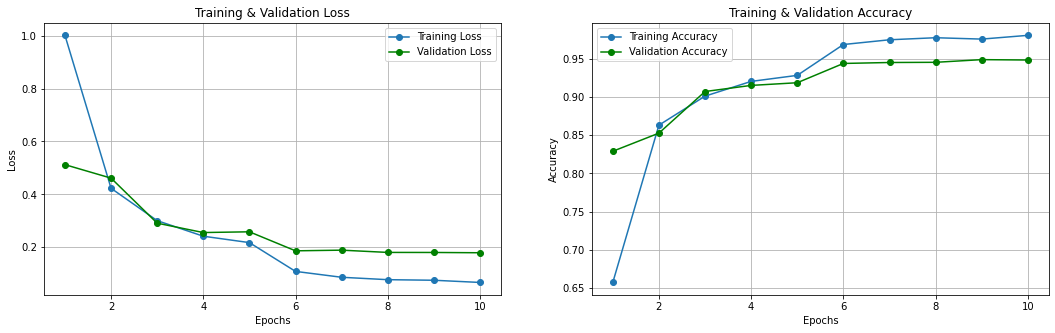

In [20]:
# data visualization
a, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(18, 5)
)

ax[0].plot(
    Epoch_Values,
    DataLossValues,
    marker='o',
    label='Training Loss'
)

ax[0].plot(
    Epoch_Values,
    Data_of_LossValuesData,
    marker='o',
    color='green',
    label='Validation Loss'
)

ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

Accuracy_Values = DataHistoryValues.history['accuracy']
Data_Accuracy_Values = DataHistoryValues.history['val_accuracy']

ax[1].plot(
    Epoch_Values,
    Accuracy_Values,
    marker='o',
    label='Training Accuracy'
)

ax[1].plot(
    Epoch_Values,
    Data_Accuracy_Values,
    marker='o',
    color='green',
    label='Validation Accuracy'
)

ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()
a.savefig('LossAndAccuracy.eps', format='eps')
plt.close()
del DataLossValues, Data_of_LossValuesData, Epoch_Values, Accuracy_Values, Data_Accuracy_Values

In [21]:
# generate accuracy
Test_2_F = DG4TestData.flow_from_dataframe(
    Data_Frame2,
    x_col='Filepath_Name',
    y_col='Target_F_Name',
    target_size=(224, 224),
    interpolation='lanczos',
    validate_filenames=False
)

Score_Values = my_model.evaluate(Test_2_F)
print(Score_Values)

Found 12179 non-validated image filenames belonging to 10 classes.
381/381 [==============================] - 142s 372ms/step - loss: 0.1770 - accuracy: 0.9518
[0.17702540755271912, 0.9518022537231445]
